In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 12.8 MB/s 
     |████████████████████████████████| 1.6 MB 46.8 MB/s 


In [ ]:
pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=d652ccd5a3e3d9924a35e1aa88ce383fcadcef9864c0a24ac878b00e64f72376
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install optimizers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.7 MB/s 
  Created wheel for optimizers: filename=Optimizers-2.1-py3-none-any.whl size=2282 sha256=61f83ad22895750cb2ac93abdfcc925d8bf0cb02d8aab138586ab314b4f05101
  Stored in directory: /root/.cache/pip/wheels/56/a5/4d/f679a391b5fca0b18c5e2fcd66ebff8900d97d6d95713915b9
Successfully built optimizers
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import os
import string
import datetime
import gensim
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
import tensorflow.keras as keras
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import os.path
import shutil
import wget

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Input,concatenate,Activation, Dense, Dropout, Embedding, Flatten,Bidirectional, LSTM
from keras.models import Model
from keras.initializers import Constant
from tensorflow.keras.optimizers import Adam



def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:

pd.set_option('display.max_colwidth',100)

Dataset import and features selection

In [ ]:

if not os.path.isfile('amazon_reviews.txt'):
    url = 'https://drive.google.com/uc?id=1-LYI_s6oZ0OTe3I0vFYRYIBVhjFswReY&export=download'
    print('Downloading DB to train')
    wget.download(url)
    print('Download Completed!\nUnzipping...')
    shutil.unpack_archive('amazon_reviews.zip')
else:
   print("The dataset is already downloaded")   

df = pd.read_csv('amazon_reviews.txt', error_bad_lines=False, delimiter="\t")
df.head()

Download Completed!
Unzipping...


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,1,__label1__,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will save the day. Just keep it around just in case you ne..."
1,2,__label1__,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement 3200mAh Li-Ion Battery for Samsung Galaxy Note 3 [...,New era for batteries,Lithium batteries are something new introduced in the market there average developing cost is re...
2,3,__label1__,3,N,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 months now and has pretty much out grown it. It is ...
3,4,__label1__,4,N,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolatur and here it is. It works and does everything I ...
4,5,__label1__,4,N,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitening System - No Sensitivity,Only use twice a week,I only use it twice a week and the results are great. I have used other teeth whitening solution...


In [ ]:
features = ["REVIEW_TEXT", "RATING", "LABEL", "VERIFIED_PURCHASE"]
df = df[features]
df.head()

,REVIEW_TEXT,RATING,LABEL,VERIFIED_PURCHASE
0,"When least you think so, this product will save the day. Just keep it around just in case you ne...",4,__label1__,N
1,Lithium batteries are something new introduced in the market there average developing cost is re...,4,__label1__,Y
2,I purchased this swing for my baby. She is 6 months now and has pretty much out grown it. It is ...,3,__label1__,N
3,I was looking for an inexpensive desk calcolatur and here it is. It works and does everything I ...,4,__label1__,N
4,I only use it twice a week and the results are great. I have used other teeth whitening solution...,4,__label1__,N


Data pre-processing

In [ ]:

df['LABEL'] = pd.Categorical(df['LABEL'])
df['LABEL'] = df['LABEL'].cat.codes

In [ ]:

df['VERIFIED_PURCHASE'] = pd.Categorical(df['VERIFIED_PURCHASE'])
df['VERIFIED_PURCHASE'] = df['VERIFIED_PURCHASE'].cat.codes

In [ ]:
def remove_punctuation(txt):
 
  text_lower = "".join([c.lower() for c in txt])
  
  txt_nonpunct = "".join([c for c in text_lower if c not in string.punctuation])
  return txt_nonpunct

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'frequency of both labels')

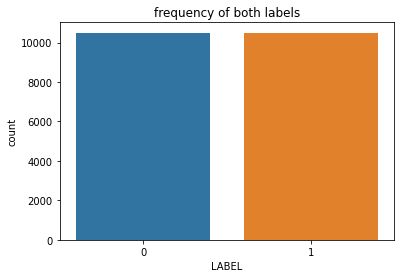

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(df.LABEL)
plt.title("frequency of both labels")

In [ ]:

df['REVIEW_TEXT'] = df['REVIEW_TEXT'].apply(lambda x: remove_punctuation(x))

In [ ]:
df.head()

,REVIEW_TEXT,RATING,LABEL,VERIFIED_PURCHASE
0,when least you think so this product will save the day just keep it around just in case you need...,4,0,0
1,lithium batteries are something new introduced in the market there average developing cost is re...,4,0,1
2,i purchased this swing for my baby she is 6 months now and has pretty much out grown it it is ve...,3,0,0
3,i was looking for an inexpensive desk calcolatur and here it is it works and does everything i n...,4,0,0
4,i only use it twice a week and the results are great i have used other teeth whitening solutions...,4,0,0


In [ ]:

train_size=0.8

X = df.copy()


X_train, X_rem= train_test_split(X, train_size=train_size)


test_size = 0.5
X_valid, X_test = train_test_split(X_rem, test_size=0.5)

In [ ]:

train_rating = X_train.pop('RATING')
valid_rating = X_valid.pop('RATING')
test_rating = X_test.pop('RATING')


train_pursh = X_train.pop('VERIFIED_PURCHASE')
valid_pursh = X_valid.pop('VERIFIED_PURCHASE')
test_pursh = X_test.pop('VERIFIED_PURCHASE')


train_target = X_train.pop('LABEL')
valid_target = X_valid.pop('LABEL')
test_target = X_test.pop('LABEL')

In [ ]:
oov_token = "<OOV>"
max_length = 100
padding_type = "post"
trunction_type="post"

In [ ]:
tokenizer = Tokenizer(oov_token=oov_token)
tokenizer.fit_on_texts(X_train.REVIEW_TEXT)
vocab_size = len(tokenizer.word_index)+1
print('Vocab Size is ',vocab_size)

Vocab Size is  40911


In [ ]:

X_train_sequences = tokenizer.texts_to_sequences(X_train.REVIEW_TEXT)
X_train_padded = pad_sequences(X_train_sequences,maxlen=max_length, padding=padding_type, 
                       truncating=trunction_type)


X_val_sequences = tokenizer.texts_to_sequences(X_valid.REVIEW_TEXT)
X_val_padded = pad_sequences(X_val_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=trunction_type)


X_test_sequences = tokenizer.texts_to_sequences(X_test.REVIEW_TEXT)
X_test_padded = pad_sequences(X_test_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=trunction_type)

Pre-Trained word embeddings - Word2Vec

In [ ]:
documents = []
# We split each text of the "REVIEW_TEXT" column
for _text in X_train.REVIEW_TEXT:    
    documents.append((_text.split(" ")))

In [ ]:
W2V_SIZE = 100
W2V_WINDOW = 7
W2V_EPOCH = 64
W2V_MIN_COUNT = 5
W2V_SG = 1 


w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            sg = W2V_SG,
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT,
                                            workers=8)


w2v_model.build_vocab(documents)

In [ ]:

w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(51976345, 75172992)

In [ ]:

w2v_model.wv.most_similar("bad")

[('good', 0.5183528065681458),
 ('poor', 0.5037727952003479),
 ('stink', 0.4789120554924011),
 ('disappointing', 0.4728483557701111),
 ('ripping', 0.4645020067691803),
 ('terrible', 0.4584123492240906),
 ('horrible', 0.4580979645252228),
 ('worse', 0.4569457471370697),
 ('sucks', 0.4446253180503845),
 ('but', 0.43943509459495544)]

In [ ]:

embedding_matrix = np.zeros((vocab_size , W2V_SIZE))
for word , i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(40911, 100)


The model

In [ ]:
embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                            max_length,
                            embeddings_initializer= Constant(embedding_matrix),
                            trainable=False)

In [ ]:
review_branch_ip = Input(shape=(100,), name='Review_input')
review_branch = embedding_layer(review_branch_ip)
review_branch = Dropout(0.2)(review_branch)
review_branch = Bidirectional(
    LSTM(64, dropout=0.2,recurrent_dropout=0)
)(review_branch)
review_branch = Dense(64,activation='relu')(review_branch)
review_branch_op = Dense(16, activation='relu')(review_branch)


rating_branch_ip = Input(shape=(1,), name='Rating_input')
rating_branch = Dense(8,activation='relu')(rating_branch_ip)
rating_branch = Dropout(0.2)(rating_branch)
rating_branch_op = Dense(16,activation='relu')(rating_branch)




verified_purchase_branch_ip = Input(shape=(1,), name='Verified_Purchase_input')
verified_purchase_branch = Dense(8,activation='relu')(verified_purchase_branch_ip)
verified_purchase_branch = Dropout(0.2)(verified_purchase_branch)
verified_purchase_branch_op = Dense(16,activation='relu')(verified_purchase_branch)


concat = concatenate([review_branch_op, rating_branch_op, verified_purchase_branch_op], name='Concatenate')


final_op = Dense(8, activation='relu')(concat)
final_output = Dense(1,activation='sigmoid')(final_op)

model = Model(inputs=[review_branch_ip,rating_branch_ip,verified_purchase_branch_ip], outputs=final_output,
                  name='Final_output')

In [ ]:

model.compile(optimizer=Adam(clipvalue=0.5) , 
              loss='binary_crossentropy', 
              metrics=['acc'])

In [ ]:

model.summary()

Model: "Final_output"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Review_input (InputLayer)      [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 100)     4091100     ['Review_input[0][0]']           
                                                                                                  
 dropout_3 (Dropout)            (None, 100, 100)     0           ['embedding[0][0]']              
                                                                                                  
 Rating_input (InputLayer)      [(None, 1)]          0           []                               
                                                                                       

In [ ]:
stop_early_model = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit([X_train_padded,train_rating,train_pursh], train_target, batch_size=32,epochs=20, validation_data=([X_val_padded,valid_rating,valid_pursh], valid_target),callbacks=[stop_early_model])


Epoch 1/20
525/525 [==============================] - 54s 95ms/step - loss: 0.5581 - acc: 0.7515 - val_loss: 0.4920 - val_acc: 0.7962
Epoch 2/20
525/525 [==============================] - 49s 93ms/step - loss: 0.4864 - acc: 0.7839 - val_loss: 0.4738 - val_acc: 0.8029
Epoch 3/20
525/525 [==============================] - 49s 93ms/step - loss: 0.4649 - acc: 0.7971 - val_loss: 0.4532 - val_acc: 0.8138
Epoch 4/20
525/525 [==============================] - 49s 93ms/step - loss: 0.4611 - acc: 0.7989 - val_loss: 0.4517 - val_acc: 0.8062
Epoch 5/20
525/525 [==============================] - 49s 93ms/step - loss: 0.4491 - acc: 0.8068 - val_loss: 0.4432 - val_acc: 0.8138
Epoch 6/20
525/525 [==============================] - 49s 93ms/step - loss: 0.4401 - acc: 0.8116 - val_loss: 0.4528 - val_acc: 0.8057
Epoch 7/20
525/525 [==============================] - 49s 93ms/step - loss: 0.4362 - acc: 0.8118 - val_loss: 0.4432 - val_acc: 0.8105
Epoch 8/20
525/525 [==============================] - 49s 94ms

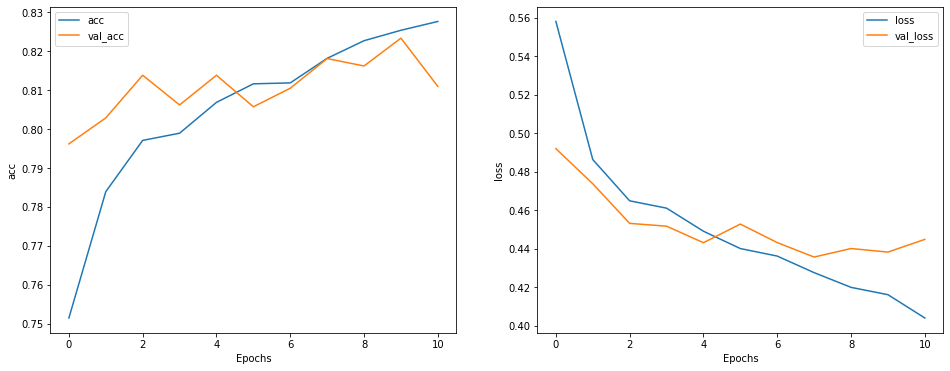

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'acc')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [ ]:
model.evaluate([X_test_padded,test_rating,test_pursh], test_target, verbose=2)

66/66 - 2s - loss: 0.4391 - acc: 0.8190 - 2s/epoch - 28ms/step


[0.4390980303287506, 0.8190476298332214]